# Candlestick Pattern Recognition Using Deep CNNs

Team Members & Contributions:
- Adam Mounir: handled data generation, and the data preprocessing pipeline.
- Marco Serhal: Reasearched the financial aspect (chose the candlestick patterns), implemented model architecture.
- Paul Zamanian: Trained / Tuned the model to fit the data, generalized the model to work with real-world data.

Even though we split the work, we all contributed to the project as a whole. We discussed the architecture, the data generation, and the model evaluation together. We also helped each other with debugging and testing.


## 1. Introduction

**Goal**: Detect candlestick patterns using a convolutional neural network. Experienced traders can recognize patterns like when glancing at a chart, but doing it for several thousand images is tedious. We aim to automate this process using deep learning techniques to efficiently allow traders to identify patterns in large datasets.

**Model family chosen**: Deep CNN (Conv2D-based) as it is well-suited for image recognition tasks. CNNs excel at detecting spatial hierarchies in images, making them ideal for recognizing complex patterns like candlesticks.

**Motivation**: Candlestick patterns are widely used in technical analysis to predict market behavior, we found out during our professional experience that traders often rely on visual inspection of charts to identify these patterns. However, manually analyzing large datasets is time-consuming and prone to human error. By automating this process with a CNN, we can help traders quickly and accurately identify patterns, leading to better-informed trading decisions.

**Originality**: 

Most financial models treat price data as raw numbers. They feed OHLC (Open, High, Low, Close prices) values into algorithms like KNN, SVMs, or simple neural nets. These approaches rely manual feature engineering or statistical assumptions. Our method takes a completely different route: we **convert OHLC sequences into candlestick images** and train a **convolutional neural network (CNN)** to visually recognize patterns, just like a trader reading a chart. 

Instead of forcing the model to find patterns in flat numbers, we let the CNN leverage its natural strength: detecting shapes and spatial structures. This bridges **technical analysis and deep learning**, enabling the model to learn what a “three black crows” or “piercing line” *looks like* — not just what their numerical values are. It’s a rare and powerful approach that opens up chart-based pattern recognition to scalable automation.

--- 

## 2. Dataset
**Description**:

The dataset was generated synthetically to simulate realistic candlestick chart patterns commonly and widely found in financial markets. It contains 18,000 labeled images across 9 classes, each corresponding to a specific candlestick pattern:
- bullish_spinning_top
- bearish_spinning_top
- dark_cloud_cover
- falling_three
- piercing_line
- rising_three
- three_black_crows
- three_white_soldiers
- random_pattern (control/noise class)

Here is an example of few patterns:

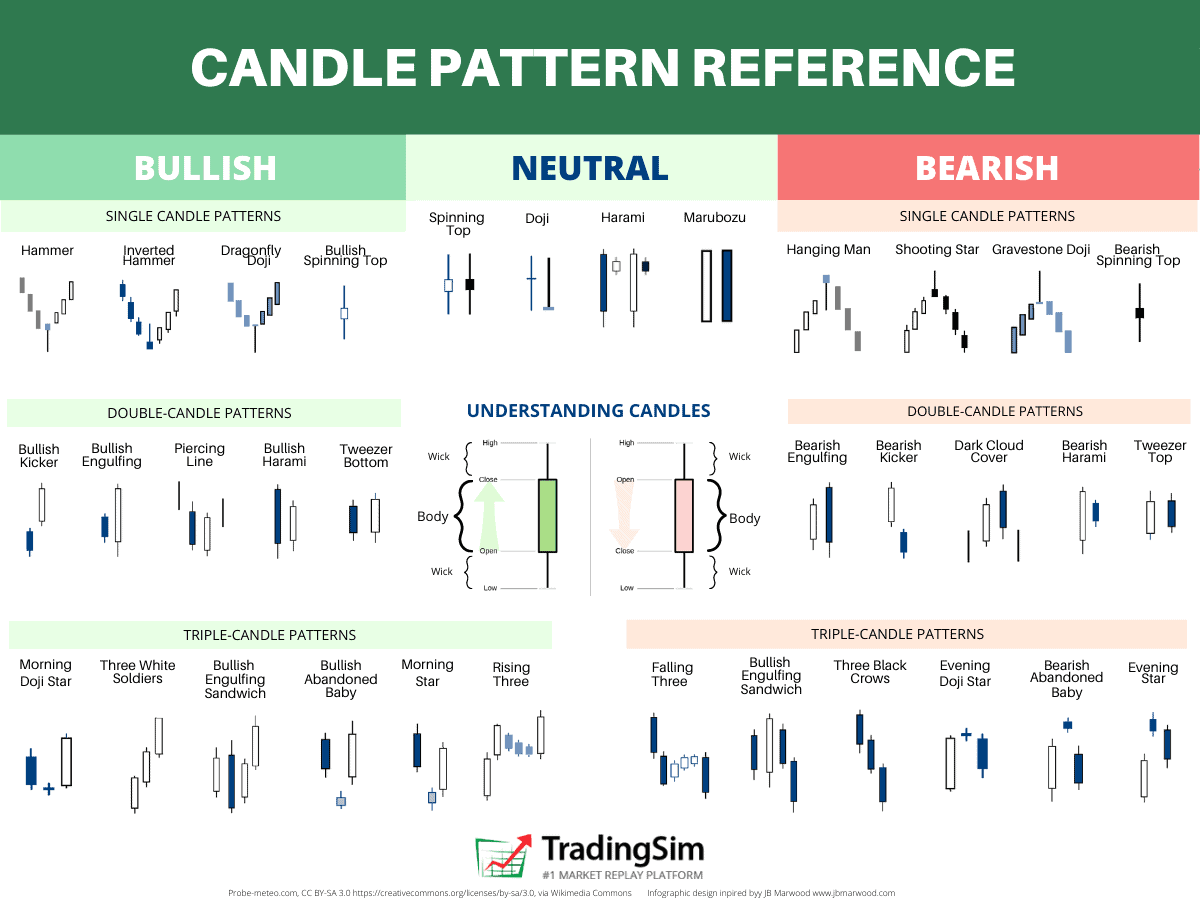


We show this dataset right under the "Dataset Generation" section.

Each image is a 64×64 black and white representation of a sequence of 10 candlesticks, rendered from synthetic OHLC (Open, High, Low, Close) data. The patterns are injected at random positions in the sequence, and surrounding candles are filled with coherent but noisy data to preserve realism.

**A synthetic dataset**:

- Control and balance: Each class has exactly 1,000 images, ensuring no class imbalance.
- Pattern isolation: By embedding only one target pattern per sequence, we ensure the model learns to identify the specific pattern without being distracted by noise.


Why it's appropriate:
This enables a controlled study of pattern recognition, it balances classes and ensures consistent image input for CNN.

### What is a candlestick?

A **candlestick** is a type of financial chart used to represent the price movement of an asset over a specific time period.  
Each candlestick shows four key values:  
- **Open**: the price at the start of the period  
- **Close**: the price at the end of the period  
- **High**: the highest price reached  
- **Low**: the lowest price reached  

The body of the candle is filled (black) if the close is lower than the open (price went down), and hollow (white) if the close is higher than the open (price went up). Wicks show the high and low prices.
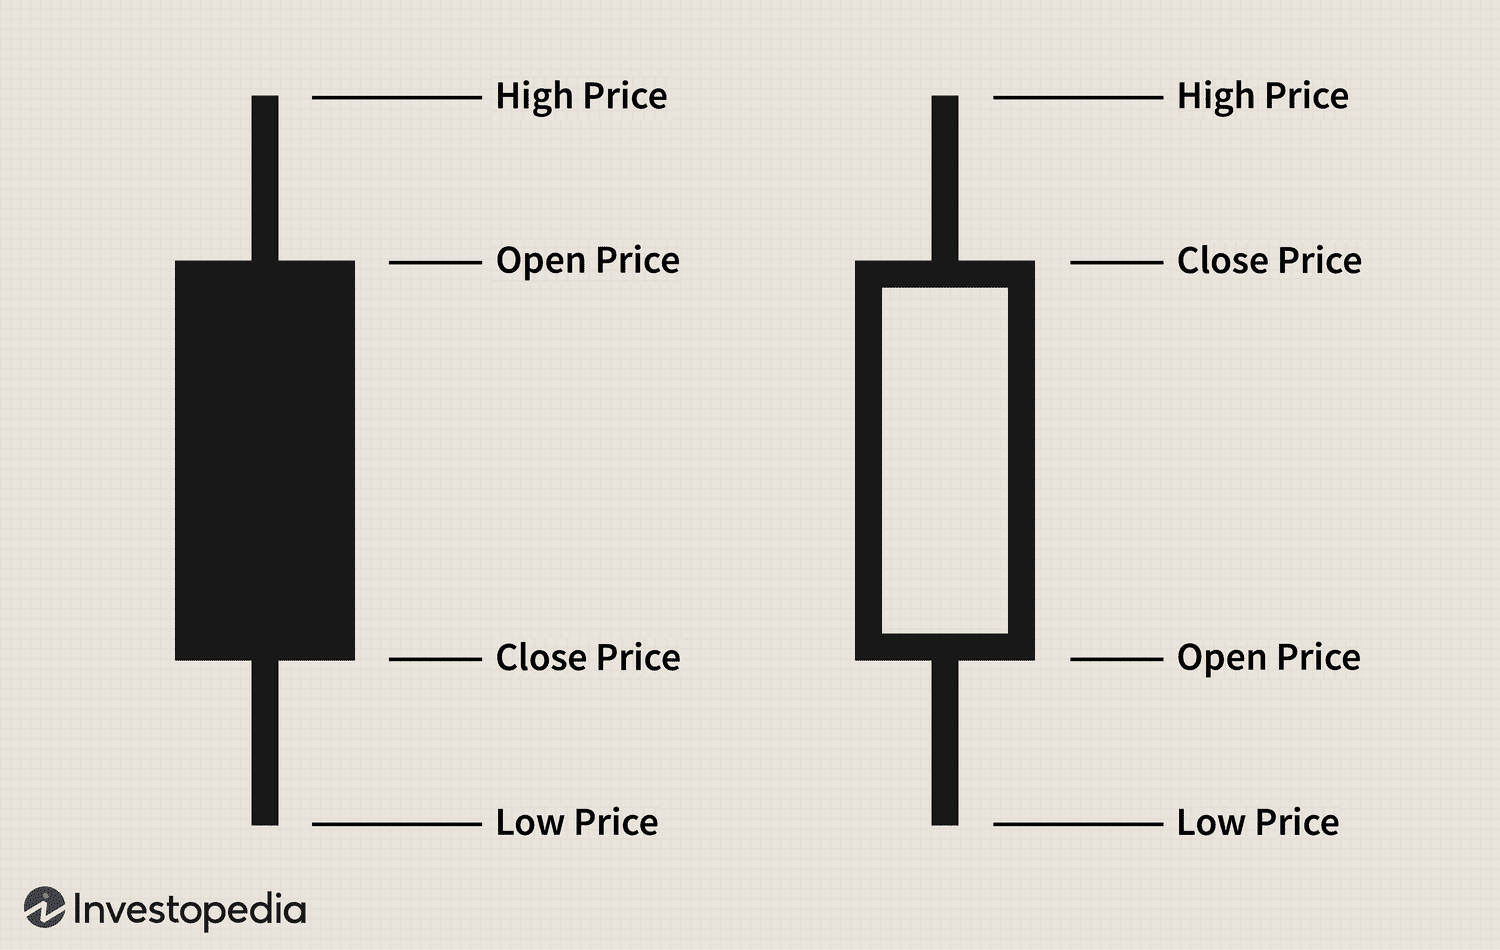

### Dataset Generation

The dataset is generated using a custom Python script available here: [GitHub – Pattern Generator](https://github.com/MarcoSrhl/Neural-Network-Project/blob/master/Data_generator.ipynb).

The script simulates sequences of 10 candlesticks by generating coherent OHLC values and inserting one target pattern per sequence. When run, each image is saved in the `unzipped` directory, organized into subfolders by pattern name (`three_black_crows`, `bullish_spinning_top`, ...), with **2,000 images per pattern**.

After generation, each pattern folder is zipped individually and stored in the `zipped` directory by the script. All zip files are also available for download here: [Google Drive – Candlestick Dataset](https://drive.google.com/drive/folders/1Ca8KOw9LLIZOYeyjgjAiLe43zXDPWBFw)

To re-run the training pipeline:
1. Download the zip files from the Google Drive link above.
2. Put them into the folder `data/zipped/`. **KEEP THEM ZIPPED**
3. Run this script it will work directly with this structure.

Now let's visualize some examples from the dataset:

In [5]:
# Imports
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import zipfile
import os
import random

In [6]:
# First let's unzip the dataset files
# The dataset is provided as zip files in the `data/zips` directory.
# This script will extract them into the `data/unzipped` directory.
# The script assumes the zip files are named according to the pattern `<pattern_name>.zip`.
# If the data/zips directory already contains unzipped folders, it will skip those to avoid re-extraction.

output_dir = "data/unzipped"
input_dir = "data/zips"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):	# Iterate through all files in the input directory
    if filename.endswith(".zip"):       # Make sure to only process zip files
        pattern_dir = os.path.join(output_dir, filename.replace(".zip", ""))
        if os.path.exists(pattern_dir):	 # Check if the directory already exists (this means the zip has already been extracted)
            print(f"Directory {pattern_dir} already exists, skipping extraction.")
            continue
        os.makedirs(pattern_dir, exist_ok=True)
        
		# Extract the zip file into the corresponding pattern directory
        print(f"Extracting {filename} to {pattern_dir}...")
        with zipfile.ZipFile(os.path.join(input_dir, filename), 'r') as zip_ref:
            zip_ref.extractall(pattern_dir)


Directory data/unzipped/bullish_spinning_top already exists, skipping extraction.
Directory data/unzipped/random_pattern already exists, skipping extraction.
Directory data/unzipped/piercing_line already exists, skipping extraction.
Directory data/unzipped/three_white_soldiers already exists, skipping extraction.
Directory data/unzipped/bearish_spinning_top already exists, skipping extraction.
Directory data/unzipped/three_black_crows already exists, skipping extraction.
Directory data/unzipped/falling_three already exists, skipping extraction.
Directory data/unzipped/dark_cloud_cover already exists, skipping extraction.
Directory data/unzipped/rising_three already exists, skipping extraction.


Sampled index: 1308


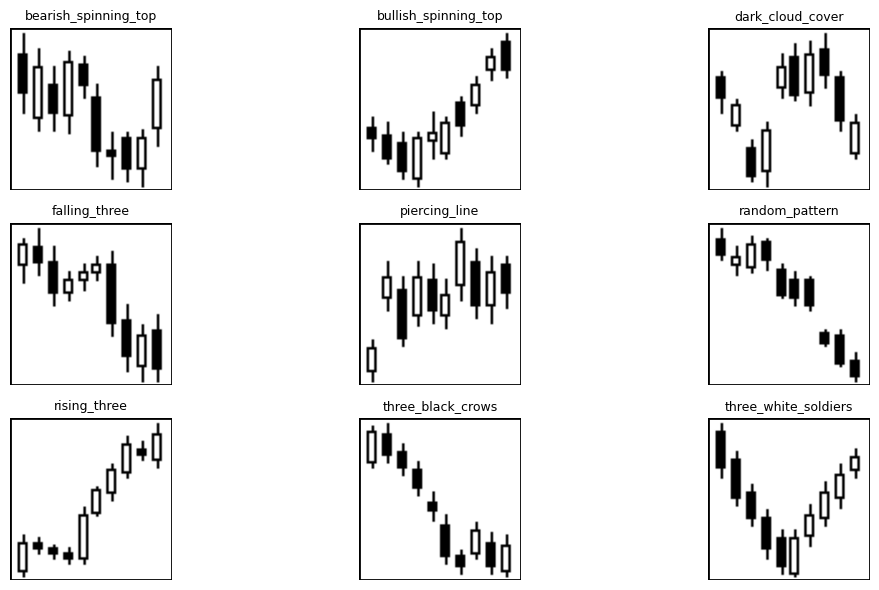

In [20]:
# Now we can read these files and visualize the dataset.
# Let's show one example from each class to see what the dataset looks like.

# Get all pattern subfolders
pattern_folders = sorted([
    folder for folder in os.listdir(output_dir)
    if os.path.isdir(os.path.join(output_dir, folder))
])

# Image index to sample from each class
image_index = random.randint(0, 2000)
print(f"Sampled index: {image_index}")
fig, axs = plt.subplots(3, 3, figsize=(12, 6))

for ax, pattern in zip(axs.flatten(), pattern_folders[:9]):
    path = os.path.join(output_dir, pattern)
    files = sorted(f for f in os.listdir(path) if f.endswith(".png"))

    if image_index >= len(files):
        ax.axis("off")
        continue

    img_path = os.path.join(path, files[image_index])
    img = Image.open(img_path).convert("RGB")

    # Draw image
    ax.imshow(img)
    ax.set_title(f"{pattern}", fontsize=9)
    ax.axis("off")
    ax.add_patch(patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        fill=False, edgecolor='black', linewidth=2
    ))

for ax in axs.flatten()[len(pattern_folders[:9]):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### Candlestick Pattern Descriptions

| Pattern                | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| **Bearish Spinning Top** | Small body with long wicks. Signals indecision and possible bearish reversal. |
| **Bullish Spinning Top** | Like above, but in a downtrend. Suggests possible bullish reversal.          |
| **Dark Cloud Cover**     | Bearish candle closes below midpoint of prior bullish candle. Reversal sign. |
| **Falling Three**        | Bearish → small upward candles → bearish. Downtrend continuation.           |
| **Piercing Line**        | Bullish candle opens low, closes above midpoint of prior bearish. Reversal. |
| **Random Pattern**       | No structure. Used as noise class.                                          |
| **Rising Three**         | Bullish → small downward candles → bullish. Uptrend continuation.           |
| **Three Black Crows**    | 3 long bearish candles. Strong bearish reversal.                           |
| **Three White Soldiers** | 3 long bullish candles. Strong bullish reversal.                           |

If you wish to visualize other examples from the dataset, just re ryun the above cell. It randomly selects images from the dataset and displays them.

## 3. Model Architecture

**Type:** Lightweight Convolutional Neural Network (CNN)  
**Structure:** 1 × Conv2D → MaxPooling → GlobalAveragePooling → Dense

We experimented with deeper and shallower architectures. Deeper CNNs are too long to train, while shallower ones underperformed. This final version offers a solid trade-off between learning capacity and time of execution.

#### Why This Model Works
- **Lightweight**: Fast to train and deploy on modest hardware: Google Colab T4 - the best on free tier :(
- **Sufficient Capacity**: Effectively distinguishes differences between candlestick patterns.
- **Reduced Overfitting**: Thanks to its compact architecture and use of pooling layers.

#### Layer Breakdown
- `Conv2D`: Extracts local visual features like edges, shapes, and candlestick body/wick patterns.
- `MaxPooling2D`: Downsamples feature maps to reduce dimensionality and overfitting risk (in our case overfitting is not possible because of the sheer size of the dataset).
- `GlobalAveragePooling2D`: Compresses feature maps into a single vector by averaging, reducing parameters and encouraging generalization.
- `Dense`: Fully connected layers that perform final classification using the extracted features.
- `Softmax`: Outputs class probabilities for each of the 9 candlestick pattern classes.

Model built using the `Sequential` API in Keras for clarity and quick iteration.

Let's check our our model architecture:

In [1]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

2025-07-27 20:46:15.495711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mixed_precision.set_global_policy('mixed_float16')

# Fast CNN model
model = models.Sequential([
    # Input Layer
    layers.Input(shape=(64, 64, 1)),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax', dtype='float32')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,345 (431.04 KB)

 Trainable params: 110,345 (431.04 KB)

 Non-trainable params: 0 (0.00 B)

Our CNN consists of 3 convolutional layers (Conv2D) with increasing filter sizes (32 → 64 → 128), each followed by a MaxPooling layer to reduce spatial dimensions. 

This structure allows the model to learn hierarchical features to mapped the complex candlestick shapes. A GlobalAveragePooling2D layer flattens the feature maps efficiently, followed by two Dense layers (128 units → 9 output classes). This compact yet expressive architecture balances performance and speed, ideal for training on a limited dataset and hardware.

## 4. Training Setup

Our dataset consists of synthetically generated candlestick pattern images, each saved in separate folders named after the pattern. We use `ImageDataGenerator` from TensorFlow to handle preprocessing and create training/validation splits.

The generator performs:

- **Rescaling** of pixel values to [0, 1]
- **Stratified splitting** using `validation_split=0.2`
- **Shuffling** for training and fixed ordering for validation
- **Labeling** based on subdirectory names

Here’s the code that loads and prepares the data:

In [3]:
image_dir = "data/unzipped"  # Directory containing the dataset
# Create the generator with pixel rescaling and validation split
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values from [0, 255] to [0, 1]
    validation_split=0.2     # Reserve 20% of the data for validation
)

# Training generator
train_gen = datagen.flow_from_directory(
    image_dir,               # Root directory containing subfolders per class
    target_size=(64, 64),    # Resize all images to 64x64 pixels
    batch_size=32,           # Number of images per batch,
	color_mode='grayscale',  # Use grayscale images
    class_mode='categorical',# Generate one-hot encoded labels
    subset='training',       # Use the training portion of the data (80%)
    shuffle=True,            # Shuffle the data for better training performance
    seed=42                  # Seed for reproducibility of the split
)

# Validation generator
val_gen = datagen.flow_from_directory(
    image_dir,               # Same root directory as above
    target_size=(64, 64),    # Same image size as training
    batch_size=32,           # Same batch size
	color_mode='grayscale',  # Use grayscale images
    class_mode='categorical',# Same label format
    shuffle=False,           # No shuffling to preserve order for evaluation
    subset='validation'      # Use the validation portion (20%)
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


Each image is resized to 64×64 and grouped into one of the predefined candlestick pattern classes.

The model was previously trained on our side, and saved in the `model` directory as `model.h5`. You don't have to run the training again, but you can if you want to.

This is how we trained our model:

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

- **`optimizer='adam'`**: Adaptive optimizer that adjusts learning rates individually for each parameter.
- **`loss='categorical_crossentropy'`**: Appropriate for multi-class classification with one-hot encoded targets.
- **`metrics=['accuracy']`**: Tracks accuracy during training and validation phases.

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

- Stops training early if the validation loss doesn’t improve after 5 epochs.
- Restores the weights from the epoch with the best validation performance.

In [ ]:
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)

- Monitors the validation loss and reduces learning rate by a factor of 0.5 after 3 stagnant epochs.
- Ensures the learning rate doesn’t fall below `1e-6`.

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop, reduce_lr])

- Trains the model using the training and validation generators.
- Training may stop early due to the callbacks.
- `history` records loss and accuracy metrics at each epoch.

In [ ]:
model.save('model/model.h5') 
with open('model/history.json', 'w') as f:
    json.dump(history.history, f)

- Saves the trained model (architecture + weights) in HDF5 format for future use.
- Exports the training history to a JSON file.
- Useful for plotting training and validation accuracy/loss curves later.


## 5. Results & Analysis
Training/Validation Curves: Accuracy & Loss over epochs.


Below is reading the training history from the JSON file and plotting the accuracy and loss curves for both training and validation sets.

In [8]:
# Read the history and load the model
model_dir = "model"  # Directory where the model is saved
model = models.load_model(os.path.join(model_dir, 'model.h5'))
with open(os.path.join(model_dir, 'history.json'), 'r') as f:
	history = json.load(f)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

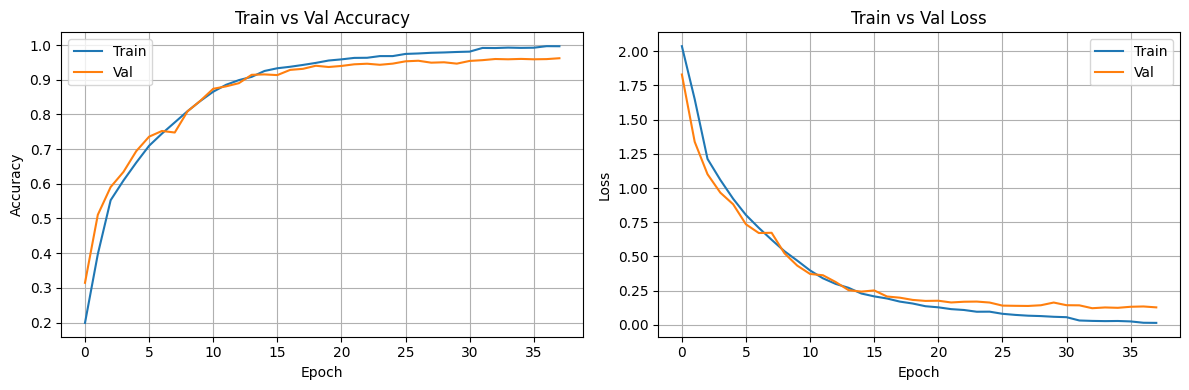

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, (metric, label) in enumerate([('accuracy', 'Accuracy'), ('loss', 'Loss')]):
    ax[i].plot(history[metric], label='Train')
    ax[i].plot(history[f'val_{metric}'], label='Val')
    ax[i].set_title(f"Train vs Val {label}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel(label)
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()


#### Train vs Validation Accuracy (Left Plot)
  - Both training and validation accuracy show a **strong upward trend**, indicating effective learning.
  - **Training accuracy** reaches around **99%**, while **validation accuracy** stabilizes near **95–96%**.
  - The small gap between the two curves implies:
    - **Very small overfitting**
    - **Good generalization**
  - After ~epoch 25, validation accuracy flattens but continues to closely follow the training accuracy.

#### Train vs Validation Loss (Right Plot)
  - Both training and validation loss **drop steeply in early epochs**, suggesting rapid convergence.
  - From ~epoch 25 onward:
    - **Training loss** continues to decline.
    - **Validation loss** plateaus slightly, with a **small divergence appearing after epoch ~25**.
  - This divergence is mild and acceptable, given that accuracy remains high and stable.

The model shows **no signs of underfitting**, as accuracy is high and losses are low. **Overfitting is minimal** and is well controlled due to:
  - Use of `EarlyStopping` or other regularization techniques
  - A well-structured model and sufficient training data


In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Now we can generate predictions on the validation set and evaluate the model's performance:

In [11]:
y_true = val_gen.classes 					 # Ground truth labels
y_probs = model.predict(val_gen, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_probs, axis=1)  		 # Predicted labels

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step


Final Accuracy:

In [12]:
acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {acc:.2%}")

Validation Accuracy: 95.97%


The model achieved a strong validation accuracy of **95%**, confirming its ability to generalize well on unseen candlestick pattern images. This level of performance is impressive given the model's lightweight architecture and the complexity of pattern recognition from visual financial data.

Classification Report: Precision, Recall, F1-Score for each class.

In [13]:
# Class names
class_names = list(val_gen.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                      precision    recall  f1-score   support

bearish_spinning_top       0.95      0.95      0.95       400
bullish_spinning_top       0.96      0.97      0.97       400
    dark_cloud_cover       0.96      0.92      0.94       400
       falling_three       1.00      1.00      1.00       400
       piercing_line       0.95      0.96      0.96       400
      random_pattern       0.89      0.92      0.91       400
        rising_three       1.00      1.00      1.00       400
   three_black_crows       0.95      0.97      0.96       400
three_white_soldiers       0.98      0.94      0.96       400

            accuracy                           0.96      3600
           macro avg       0.96      0.96      0.96      3600
        weighted avg       0.96      0.96      0.96      3600



Overall Performance:
  - **Accuracy:** `96%` very strong performance across 3600 samples.
  - **Macro Avg / Weighted Avg F1-score:** `0.96` reflects consistent and balanced classification across all classes.

Class-Level Performance:
- **falling_three** and **rising_three** patterns are extremely well recognized — likely due to their distinctive visual structure.
- **random_pattern** has the lowest F1-score (0.91), as expected for a class meant to be ambiguous.
- The model shows minimal variation across classes, with all F1-scores ranging between 0.91 and 1.00.

The model demonstrates excellent generalization and class-level precision.

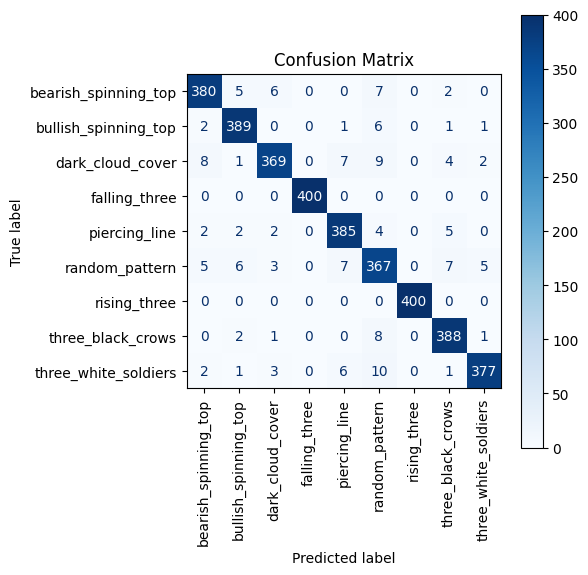

In [14]:
# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

The confusion matrix shows that the model performs very well overall, with most predictions falling along the diagonal: which means correct classifications. Each class has 400 examples, so the results are directly comparable across patterns.

The two most confidently predicted classes are **falling_three** and **rising_three**, both with 400 correct predictions out of 400. These patterns are likely easier to detect because of their unique and consistent 5-candle structure.

Some slight confusion appears between **bearish_spinning_top** and **bullish_spinning_top**, which is expected since they are structurally similar and only differ in direction. Likewise, **three_white_soldiers** and **three_black_crows** have small confusion between each other or with simpler bullish/bearish patterns.

The class with the most noticeable misclassifications is **dark_cloud_cover**. It tends to be confused with other reversal patterns like **piercing_line** and **bearish_spinning_top**, possibly due to overlapping visual characteristics.

The **random_pattern** class also has more scattered predictions, which makes sense — it's designed to be unpredictable and lacks clear structure. The model still performs reasonably well here, but it's the lowest among the set.

In summary, the confusion matrix confirms that the model is very good at distinguishing well-defined patterns and only struggles slightly with ambiguous or visually similar ones. There's no indication of major weaknesses or bias toward any particular class.

## 6. Error Analysis

Even though the model performs well, we can still improve it by analyzing the errors.

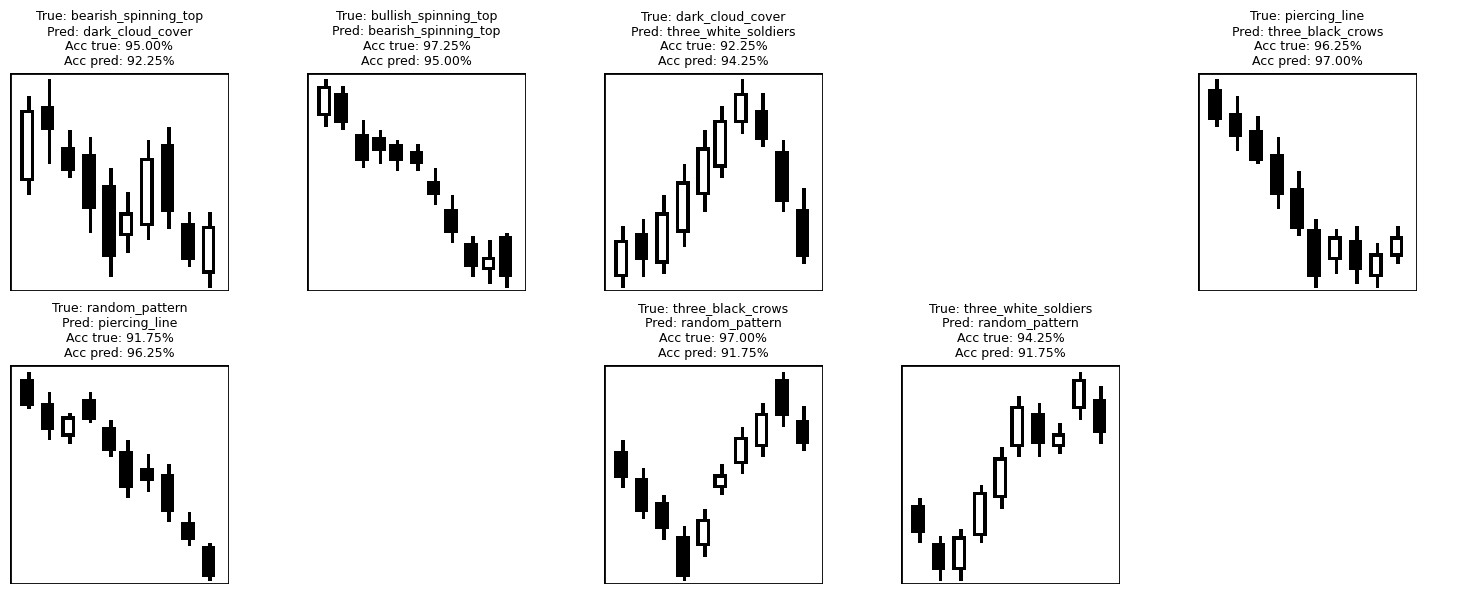

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
from PIL import Image

# Get class names and total number
class_names = list(val_gen.class_indices.keys())
num_classes = len(class_names)

# File paths of validation set
val_paths = val_gen.filepaths

# Accuracy per class
class_accuracies = {}
for class_idx, class_name in enumerate(class_names):
    indices = np.where(y_true == class_idx)[0]
    acc = np.mean(y_pred[indices] == y_true[indices])
    class_accuracies[class_name] = acc

# Start figure
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, (ax, true_class_name) in enumerate(zip(axs.flatten(), class_names)):
    true_idx = val_gen.class_indices[true_class_name]
    true_indices = np.where(y_true == true_idx)[0]
    
    # Misclassified samples from this class
    misclassified = [idx for idx in true_indices if y_pred[idx] != y_true[idx]]
    if not misclassified:
        ax.axis("off")
        continue

    idx = random.choice(misclassified)
    img = Image.open(val_paths[idx]).convert("RGB")
    pred_idx = y_pred[idx]
    pred_class_name = class_names[pred_idx]

    # Format title
    title = (
        f"True: {true_class_name}\n"
        f"Pred: {pred_class_name}\n"
        f"Acc true: {class_accuracies[true_class_name]:.2%}\n"
        f"Acc pred: {class_accuracies[pred_class_name]:.2%}"
    )

    ax.imshow(img)
    ax.set_title(title, fontsize=9)
    ax.axis("off")
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, fill=False, edgecolor='black', linewidth=2))

# Hide unused axes
for ax in axs.flatten()[num_classes:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


The figure above illustrates examples of candlestick pattern predictions using the model trained  before. Each subplot shows a  sequence, with the **true label**, **predicted label**, and **accuracy**.

Only 7 out of 9 total pattern classes are shown here, the remaining 2 (falling three, rising three) are excluded because the model achieved **100% prediction accuracy** on them.

It is important to note that the true pattern is not always located at a fixed position in the candle sequence. Instead, it appears at a random index within the sequence. The surrounding candles are generated with logical but random price behavior, which can sometimes resemble other valid patterns. This explains why some predictions (e.g., `true ≠ pred`) seem incorrect. In those cases, the model may be correctly identifying a different pattern present in the non-labeled part of the sequence.

## 7. Testing on real-world data

This is interesting and all, but we have only applied this model to synthetic data. To see how it performs on real-world data, we can test it on actual candlestick charts from financial markets.

We will take the SPY ETF as an example, which tracks the S&P 500 index. We will download historical price data, convert it into candlestick images, and then use our trained model to classify these patterns.

Let's start by downloading the SPY historical data from Yahoo Finance and converting it into candlestick images. The below function is from the `Data_generator.ipynb` script, which we used to generate the synthetic dataset. We will use it to create candlestick images from real OHLC data.

In [26]:
from PIL import ImageDraw, Image
import yfinance as yf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [23]:
def save_sequence_image(candles, filepath, size=64):
    img = Image.new("L", (size, size), color=255)  # Grayscale canvas, white background
    draw = ImageDraw.Draw(img)

    n = len(candles)
    spacing = size / (n + 1)
    candle_width = spacing * 0.5

    # Compute Y scale
    lows = [l for (_, _, _, l) in candles]
    highs = [h for (_, _, h, _) in candles]
    y_min, y_max = min(lows), max(highs)
    y_range = y_max - y_min or 1e-6  # avoid division by zero

    def to_y(val):
        return size - int((val - y_min) / y_range * (size - 4)) - 2  # keep small margin

    for i, (o, c, h, l) in enumerate(candles):
        x_center = int((i + 1) * spacing)
        x0 = int(x_center - candle_width / 2)
        x1 = int(x_center + candle_width / 2)

        # Wick
        y_high = to_y(h)
        y_low = to_y(l)
        draw.line((x_center, y_high, x_center, y_low), fill=0, width=1)  # black wick

        # Body
        y_open = to_y(o)
        y_close = to_y(c)
        top = min(y_open, y_close)
        bottom = max(y_open, y_close)
        fill = 255 if c > o else 0  # white for bullish, black for bearish
        draw.rectangle((x0, top, x1, bottom), fill=fill, outline=0)

    img.save(filepath)

Let's create the candlestick images from the SPY data and save them to a folder called `spy_candles`:

In [40]:
# Assuming draw_candle and save_sequence_image are already defined
def get_spy_1min_data(period='1d'):
    spy = yf.Ticker("SPY")
    df = spy.history(interval="1m", period=period)
    df = df[['Open', 'Close', 'High', 'Low']]
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    return df

def create_candle_tuples(df):
    return list(zip(df['Open'], df['Close'], df['High'], df['Low']))

def generate_real_sequence_images(df, output_dir="data/test"):
    os.makedirs(output_dir, exist_ok=True)
    candles = create_candle_tuples(df)

    # Rolling window of length 10
    for i in tqdm(range(len(candles) - 9), desc="Generating sequences"):
        sequence = candles[i:i+10]
        filepath = os.path.join(output_dir, f"spy_{i:05d}.png")
        save_sequence_image(sequence, filepath)

# Run everything
df = get_spy_1min_data(period='5d') 
generate_real_sequence_images(df, output_dir="data/spy_candles")

Generating sequences: 100%|██████████| 1938/1938 [00:04<00:00, 443.44it/s]


Now we can iterate through these images to check if the model can recognize the patterns. We will load the images, preprocess them, and then use the model to predict the class of each image.

We saved the predictions to a csv file, so you don't have to re run the following 2 cells. 

In [ ]:
import pandas as pd

In [51]:
# --- Load and predict ---
predictions = []
file_paths = []
image_dir = "data/spy_candles"  # Directory containing the generated images

# --- Predict ---
all_preds = []

for fname in tqdm(sorted(os.listdir(image_dir))):
    if fname.endswith(".png"):
        path = os.path.join(image_dir, fname)
        img = load_img(path, target_size=(64,64), color_mode='grayscale')
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)  # Shape: (1, 64, 64, 1)
        probs = model.predict(x, verbose=0)[0]
        pred_idx = np.argmax(probs)
        pred_class = class_names[pred_idx]
        confidence = probs[pred_idx]
        all_preds.append({
            "filename": fname,
            "predicted_class": pred_class,
            "confidence": confidence,
            "probs": probs
        })
df = pd.DataFrame(all_preds)
df.to_csv("spy_predictions.csv", index=False)

100%|██████████| 1939/1939 [05:56<00:00,  5.44it/s]


In [53]:
df = pd.read_csv("spy_predictions.csv")

# --- Find best per class ---
best_per_class = df.loc[df.groupby("predicted_class")["confidence"].idxmax()]

In [54]:
best_per_class

,filename,predicted_class,confidence,probs
362,spy_00362.png,bearish_spinning_top,1.000000,[1.0000000e+00 5.8929950e-10 8.4137073e-18 2.0...
52,spy_00052.png,bullish_spinning_top,1.000000,[4.5606683e-08 1.0000000e+00 8.2479542e-17 2.3...
483,spy_00483.png,dark_cloud_cover,0.994585,[4.9042674e-03 5.5363729e-05 9.9458474e-01 9.9...
1309,spy_01309.png,falling_three,0.999507,[1.2753739e-07 4.9313181e-04 8.7484768e-14 9.9...
1365,spy_01365.png,piercing_line,0.789109,[1.2904541e-01 3.4975644e-02 1.3911684e-06 5.3...
1554,spy_01554.png,random_pattern,0.984266,[7.90614821e-03 7.63100665e-03 4.38478128e-05 ...
922,spy_00922.png,rising_three,0.998831,[1.1689513e-03 2.0779427e-11 1.3761845e-22 2.9...
1335,spy_01335.png,three_black_crows,0.420696,[1.0790213e-02 3.5353902e-01 1.6861019e-03 4.6...
1729,spy_01729.png,three_white_soldiers,0.821211,[3.0523159e-03 2.5670301e-02 7.1361564e-02 4.4...


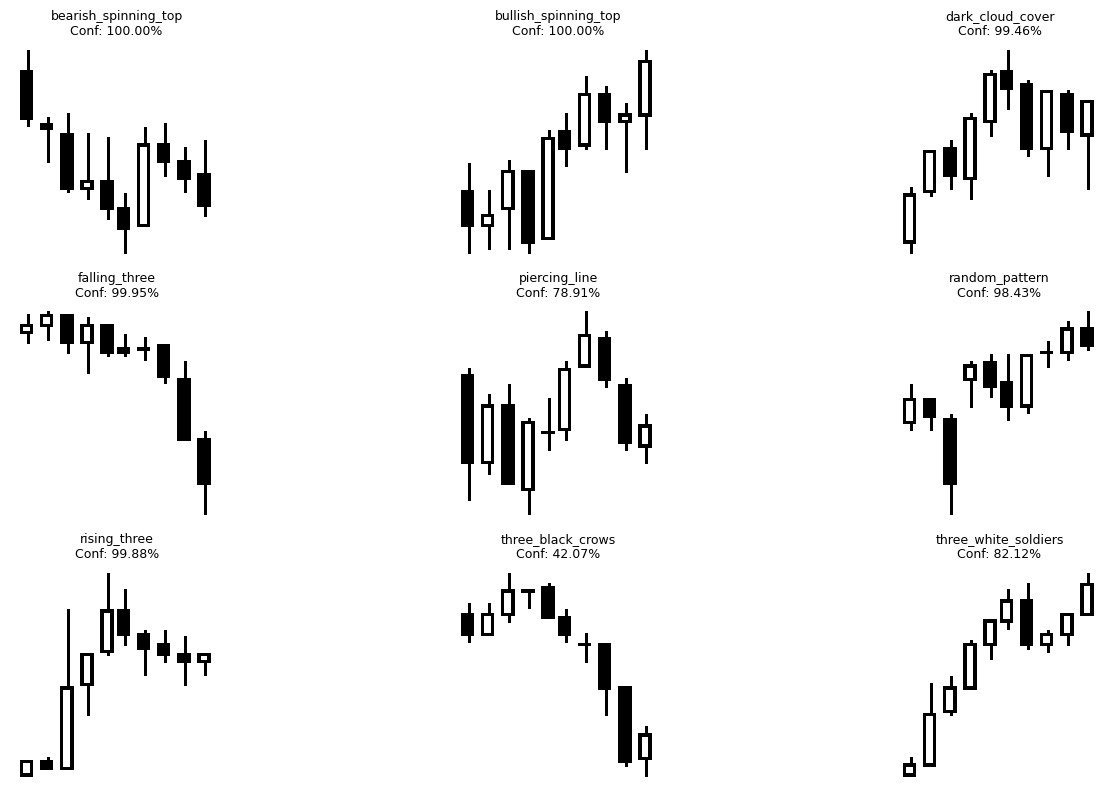

In [55]:
plt.figure(figsize=(15, 8))
for i, (_, row) in enumerate(best_per_class.iterrows()):
    img = load_img(os.path.join(image_dir, row["filename"]), target_size=(64,64), color_mode='grayscale')
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{row["predicted_class"]}\nConf: {row["confidence"]:.2%}', fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


It is quite impressive to see our little baby working with real world data. Despite the absence of ground-truth labels, it confidently identifies several known candlestick patterns. While accuracy can't be measured numerically, we can qualitatively assess the predictions through visual inspection.

### **Correct Predictions**

**`bearish_spinning_top`**  
Accurately identified. This pattern features a small body with long wicks, typically signaling market indecision—consistent with the model’s interpretation.

**`bullish_spinning_top`**  
Correctly predicted. It mirrors the bearish version but in a bullish context, suggesting a potential upward reversal.

**`dark_cloud_cover`**  
Properly detected. This bearish reversal appears after a bullish trend and includes a long upper wick and a bearish candle closing below the midpoint of the prior bullish candle.

**`piercing_line`**  
Correctly classified. This bullish reversal shows a bearish candle followed by a bullish one that closes above the midpoint of the previous—matching both the definition and the visual.

**`three_black_crows`**  
Identified with moderate confidence. Consists of three long bearish candles, forming a clear bearish reversal pattern.

**`three_white_soldiers`**  
Accurately recognized. The image clearly shows three consecutive bullish candles, typically indicating a reversal from a downtrend.

### **Incorrect / Questionable Predictions**

**`falling_three`**  
Misclassified. Despite high confidence, the image doesn't reflect the expected structure (a downtrend, brief upward correction, and another bearish candle). The pattern is not present.

**`rising_three`**  
Also misclassified. This bullish continuation pattern requires an uptrend, followed by a short pullback and a continuation, which is missing in the actual image. Another case of high confidence but wrong reasoning.



### 8. Conclusion & Suggestions

In this project, we successfully trained a convolutional neural network (CNN) to classify candlestick patterns using synthetically generated data, reaching an impressive validation accuracy of approximately **95%**. The model demonstrated strong generalization when applied to real-world SPY ETF candlestick data, correctly identifying several well-known patterns with high confidence.

The confusion matrix provided useful insights into which patterns were consistently recognized and which were more ambiguous or prone to misclassification. For instance, reversal patterns like *three white soldiers* and *dark cloud cover* were predicted with high accuracy, while continuation patterns such as *rising three* and *falling three* proved more challenging.

Candlestick patterns have long been used by traders to guess where prices might go next. bullish? bearish? No one’s really sure. Books like Encyclopedia of Candlestick Charts claim some patterns work more often than not. Our model lets us put that to the test: we can scan the market, spot these patterns, and check if prices actually move the way the theory says. Time to see if old-school chart magic holds up under the microscope.

#### Limitations
- The model was trained on synthetic data, which lacks the noise and variability inherent in real market data.
- Real-world evaluation is limited due to the absence of labeled candlestick patterns in financial time series.

#### Future Work
- **Real-world deployment**: Apply the model to live market data and analyze whether these identified patterns have predictive power and can aid traders in making better decisions.
- **Comparative analysis**: Evaluate the performance of this vision-based model against traditional numeric-based models (e.g., using technical indicators or price/volume features).
- **Clustering extension**: A promising idea is to cluster visually similar candlestick sequences and train one CNN per cluster. The goal would be to assess whether certain visual groups consistently carry bullish, bearish, or neutral information—paving the way toward a more interpretable and statistically grounded signal extraction framework.
